In [1]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import albumentations as albu
import segmentation_models as sm
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import cv2

Segmentation Models: using `tf.keras` framework.


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
BACKBONE = 'mobilenetv2'

In [4]:
heigh = 320

In [5]:
class datasetcreator:
   def __init__(self,preprocess) -> None:
      self.preprocess = preprocess

   def get_mask(self,image):
      return tf.strings.split(image,os.path.sep)[-1]

   def process_image_with_mask(self,file_path):
      image = tf.io.read_file(file_path)
      image = tf.image.decode_png(image)
      mask = self.maskspath + self.get_mask(file_path)
      mask = tf.io.read_file(mask)
      mask = tf.image.decode_png(mask)
      cond = tf.greater_equal(mask,1)
      mask = tf.where(cond,1,0)
      image = tf.cast(image,tf.uint8)
      mask = tf.cast(mask,tf.uint8)
      return image,mask
   
   def aug_fn(self,image, mask):
      image = image[:,:,:3]
      data = {"image":image,"mask":mask}
      aug_data = self.transforms(**data)
      image = aug_data["image"]
      mask = aug_data["mask"]
      image = tf.cast(image, tf.float32)
      mask = tf.cast(mask, tf.float32)
      image = self.preprocess(image)
      return image,mask
   
   def process_data(self,image, mask):
    image,mask = tf.numpy_function(self.aug_fn,inp = (image,mask),Tout=(tf.float32,tf.float32))
    return image, mask

   def __call__(self,imagepath,maskspath,transforms):
      self.transforms = transforms
      self.maskspath = maskspath
      dataset = tf.data.Dataset.list_files(imagepath)
      dataset = dataset.map(self.process_image_with_mask)
      dataset = dataset.map(self.process_data)
      return dataset.batch(4)

In [6]:
dataset = datasetcreator(sm.get_preprocessing(BACKBONE))

In [7]:
valdata = dataset('crosval/val/*png','castom-masks/masks_machine/',albu.Compose([albu.Resize(heigh,heigh,always_apply=True)]))
len(valdata)

4

In [8]:
traindata = dataset('crosval/train/*png','castom-masks/masks_machine/',albu.Compose([albu.Resize(heigh,heigh,always_apply=True)]))
len(traindata)

16

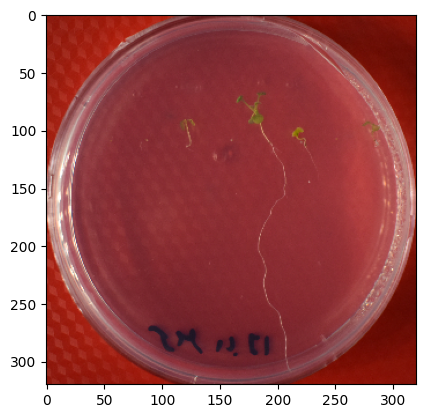

tf.Tensor([], shape=(0,), dtype=float32)


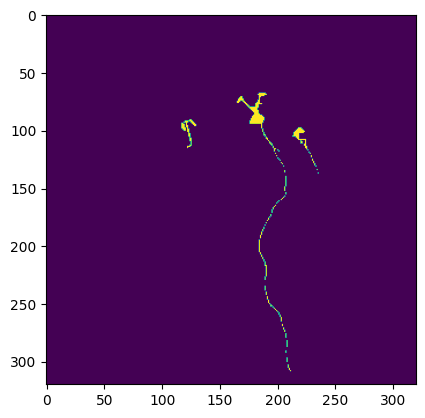

In [9]:
for image,mask in traindata.take(1):
        plt.imshow(tf.keras.utils.array_to_img(image[0]))
        plt.pause(1)
        plt.imshow(tf.keras.utils.array_to_img(mask[0]))
        print(mask[mask > 1])

In [10]:
model = sm.Unet(BACKBONE, encoder_weights='imagenet')
model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])

c:\Users\neden\miniconda3\envs\tf\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [11]:
#tf.keras.utils.plot_model(model)

In [12]:
def scheduler(epoch, lr):
  if epoch < 10 or epoch % 2 == 1:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

callback =[
    tf.keras.callbacks.EarlyStopping(min_delta=0.0001,patience=10,verbose=1),
    tf.keras.callbacks.LearningRateScheduler(scheduler,verbose=1),
    tf.keras.callbacks.ModelCheckpoint(filepath='libbestmodel/',save_best_only=True,monitor='loss',verbose=1)
]

In [13]:
# fit model
model_history = model.fit(
    traindata,
    epochs=30,
    validation_data=valdata,
    callbacks=callback,
    )


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/30
16/16 [==============================] - ETA: 0s - loss: 1.6974 - iou_score: 0.0114
Epoch 1: loss improved from inf to 1.69742, saving model to libbestmodel\


INFO:tensorflow:Assets written to: libbestmodel\assets


INFO:tensorflow:Assets written to: libbestmodel\assets


16/16 [==============================] - 45s 2s/step - loss: 1.6974 - iou_score: 0.0114 - val_loss: 1.1558 - val_iou_score: 2.5014e-05 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/30
16/16 [==============================] - ETA: 0s - loss: 1.3072 - iou_score: 0.0151
Epoch 2: loss improved from 1.69742 to 1.30715, saving model to libbestmodel\


INFO:tensorflow:Assets written to: libbestmodel\assets


INFO:tensorflow:Assets written to: libbestmodel\assets


16/16 [==============================] - 28s 2s/step - loss: 1.3072 - iou_score: 0.0151 - val_loss: 2.1811 - val_iou_score: 0.0107 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/30
16/16 [==============================] - ETA: 0s - loss: 1.1308 - iou_score: 0.0277
Epoch 3: loss improved from 1.30715 to 1.13083, saving model to libbestmodel\


INFO:tensorflow:Assets written to: libbestmodel\assets


INFO:tensorflow:Assets written to: libbestmodel\assets


16/16 [==============================] - 28s 2s/step - loss: 1.1308 - iou_score: 0.0277 - val_loss: 1.1963 - val_iou_score: 0.0176 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/30
16/16 [==============================] - ETA: 0s - loss: 1.0277 - iou_score: 0.0660
Epoch 4: loss improved from 1.13083 to 1.02767, saving model to libbestmodel\


INFO:tensorflow:Assets written to: libbestmodel\assets


INFO:tensorflow:Assets written to: libbestmodel\assets


16/16 [==============================] - 28s 2s/step - loss: 1.0277 - iou_score: 0.0660 - val_loss: 1.4861 - val_iou_score: 0.0313 - lr: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 5/30
16/16 [==============================] - ETA: 0s - loss: 0.9325 - iou_score: 0.1234
Epoch 5: loss improved from 1.02767 to 0.93254, saving model to libbestmodel\


INFO:tensorflow:Assets written to: libbestmodel\assets


INFO:tensorflow:Assets written to: libbestmodel\assets


16/16 [==============================] - 28s 2s/step - loss: 0.9325 - iou_score: 0.1234 - val_loss: 3.1167 - val_iou_score: 0.0227 - lr: 0.0010

Epoch 6: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 6/30
16/16 [==============================] - ETA: 0s - loss: 0.8315 - iou_score: 0.2012
Epoch 6: loss improved from 0.93254 to 0.83153, saving model to libbestmodel\


INFO:tensorflow:Assets written to: libbestmodel\assets


INFO:tensorflow:Assets written to: libbestmodel\assets


16/16 [==============================] - 28s 2s/step - loss: 0.8315 - iou_score: 0.2012 - val_loss: 1.0569 - val_iou_score: 0.0321 - lr: 0.0010

Epoch 7: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 7/30
16/16 [==============================] - ETA: 0s - loss: 0.7088 - iou_score: 0.3202
Epoch 7: loss improved from 0.83153 to 0.70875, saving model to libbestmodel\


INFO:tensorflow:Assets written to: libbestmodel\assets


INFO:tensorflow:Assets written to: libbestmodel\assets


16/16 [==============================] - 28s 2s/step - loss: 0.7088 - iou_score: 0.3202 - val_loss: 1.0282 - val_iou_score: 0.0765 - lr: 0.0010

Epoch 8: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 8/30
16/16 [==============================] - ETA: 0s - loss: 0.5954 - iou_score: 0.4304
Epoch 8: loss improved from 0.70875 to 0.59544, saving model to libbestmodel\


INFO:tensorflow:Assets written to: libbestmodel\assets


INFO:tensorflow:Assets written to: libbestmodel\assets


16/16 [==============================] - 32s 2s/step - loss: 0.5954 - iou_score: 0.4304 - val_loss: 0.9556 - val_iou_score: 0.1244 - lr: 0.0010

Epoch 9: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 9/30
16/16 [==============================] - ETA: 0s - loss: 0.5003 - iou_score: 0.5157
Epoch 9: loss improved from 0.59544 to 0.50027, saving model to libbestmodel\


INFO:tensorflow:Assets written to: libbestmodel\assets


INFO:tensorflow:Assets written to: libbestmodel\assets


16/16 [==============================] - 29s 2s/step - loss: 0.5003 - iou_score: 0.5157 - val_loss: 1.0541 - val_iou_score: 0.0239 - lr: 0.0010

Epoch 10: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 10/30
16/16 [==============================] - ETA: 0s - loss: 0.4505 - iou_score: 0.5673
Epoch 10: loss improved from 0.50027 to 0.45055, saving model to libbestmodel\


INFO:tensorflow:Assets written to: libbestmodel\assets


INFO:tensorflow:Assets written to: libbestmodel\assets


16/16 [==============================] - 30s 2s/step - loss: 0.4505 - iou_score: 0.5673 - val_loss: 0.9914 - val_iou_score: 0.0676 - lr: 0.0010

Epoch 11: LearningRateScheduler setting learning rate to 0.0009048373904079199.
Epoch 11/30
16/16 [==============================] - ETA: 0s - loss: 0.4106 - iou_score: 0.6019
Epoch 11: loss improved from 0.45055 to 0.41060, saving model to libbestmodel\


INFO:tensorflow:Assets written to: libbestmodel\assets


INFO:tensorflow:Assets written to: libbestmodel\assets


16/16 [==============================] - 29s 2s/step - loss: 0.4106 - iou_score: 0.6019 - val_loss: 0.9133 - val_iou_score: 0.1272 - lr: 9.0484e-04

Epoch 12: LearningRateScheduler setting learning rate to 0.0009048373904079199.
Epoch 12/30
16/16 [==============================] - ETA: 0s - loss: 0.3948 - iou_score: 0.6121
Epoch 12: loss improved from 0.41060 to 0.39485, saving model to libbestmodel\


INFO:tensorflow:Assets written to: libbestmodel\assets


INFO:tensorflow:Assets written to: libbestmodel\assets


16/16 [==============================] - 29s 2s/step - loss: 0.3948 - iou_score: 0.6121 - val_loss: 0.8844 - val_iou_score: 0.1569 - lr: 9.0484e-04

Epoch 13: LearningRateScheduler setting learning rate to 0.0008187306812033057.
Epoch 13/30
16/16 [==============================] - ETA: 0s - loss: 0.3693 - iou_score: 0.6348
Epoch 13: loss improved from 0.39485 to 0.36927, saving model to libbestmodel\


INFO:tensorflow:Assets written to: libbestmodel\assets


INFO:tensorflow:Assets written to: libbestmodel\assets


16/16 [==============================] - 29s 2s/step - loss: 0.3693 - iou_score: 0.6348 - val_loss: 0.9460 - val_iou_score: 0.1132 - lr: 8.1873e-04

Epoch 14: LearningRateScheduler setting learning rate to 0.0008187306812033057.
Epoch 14/30
16/16 [==============================] - ETA: 0s - loss: 0.3514 - iou_score: 0.6648
Epoch 14: loss improved from 0.36927 to 0.35140, saving model to libbestmodel\


INFO:tensorflow:Assets written to: libbestmodel\assets


INFO:tensorflow:Assets written to: libbestmodel\assets


16/16 [==============================] - 29s 2s/step - loss: 0.3514 - iou_score: 0.6648 - val_loss: 0.8669 - val_iou_score: 0.1915 - lr: 8.1873e-04

Epoch 15: LearningRateScheduler setting learning rate to 0.000740818097256124.
Epoch 15/30
16/16 [==============================] - ETA: 0s - loss: 0.3335 - iou_score: 0.6739
Epoch 15: loss improved from 0.35140 to 0.33351, saving model to libbestmodel\


INFO:tensorflow:Assets written to: libbestmodel\assets


INFO:tensorflow:Assets written to: libbestmodel\assets


16/16 [==============================] - 28s 2s/step - loss: 0.3335 - iou_score: 0.6739 - val_loss: 0.7226 - val_iou_score: 0.3238 - lr: 7.4082e-04

Epoch 16: LearningRateScheduler setting learning rate to 0.000740818097256124.
Epoch 16/30
16/16 [==============================] - ETA: 0s - loss: 0.3173 - iou_score: 0.6905
Epoch 16: loss improved from 0.33351 to 0.31726, saving model to libbestmodel\


INFO:tensorflow:Assets written to: libbestmodel\assets


INFO:tensorflow:Assets written to: libbestmodel\assets


16/16 [==============================] - 28s 2s/step - loss: 0.3173 - iou_score: 0.6905 - val_loss: 0.7600 - val_iou_score: 0.2819 - lr: 7.4082e-04

Epoch 17: LearningRateScheduler setting learning rate to 0.000670319888740778.
Epoch 17/30
16/16 [==============================] - ETA: 0s - loss: 0.3131 - iou_score: 0.6987
Epoch 17: loss improved from 0.31726 to 0.31310, saving model to libbestmodel\


INFO:tensorflow:Assets written to: libbestmodel\assets


INFO:tensorflow:Assets written to: libbestmodel\assets


16/16 [==============================] - 28s 2s/step - loss: 0.3131 - iou_score: 0.6987 - val_loss: 0.7712 - val_iou_score: 0.2721 - lr: 6.7032e-04

Epoch 18: LearningRateScheduler setting learning rate to 0.000670319888740778.
Epoch 18/30
16/16 [==============================] - ETA: 0s - loss: 0.2974 - iou_score: 0.7138
Epoch 18: loss improved from 0.31310 to 0.29735, saving model to libbestmodel\


INFO:tensorflow:Assets written to: libbestmodel\assets


INFO:tensorflow:Assets written to: libbestmodel\assets


16/16 [==============================] - 29s 2s/step - loss: 0.2974 - iou_score: 0.7138 - val_loss: 0.7517 - val_iou_score: 0.2889 - lr: 6.7032e-04

Epoch 19: LearningRateScheduler setting learning rate to 0.0006065304623916745.
Epoch 19/30
16/16 [==============================] - ETA: 0s - loss: 0.3012 - iou_score: 0.7055
Epoch 19: loss did not improve from 0.29735
16/16 [==============================] - 6s 372ms/step - loss: 0.3012 - iou_score: 0.7055 - val_loss: 0.8352 - val_iou_score: 0.2131 - lr: 6.0653e-04

Epoch 20: LearningRateScheduler setting learning rate to 0.0006065304623916745.
Epoch 20/30
16/16 [==============================] - ETA: 0s - loss: 0.2836 - iou_score: 0.7236
Epoch 20: loss improved from 0.29735 to 0.28363, saving model to libbestmodel\


INFO:tensorflow:Assets written to: libbestmodel\assets


INFO:tensorflow:Assets written to: libbestmodel\assets


16/16 [==============================] - 28s 2s/step - loss: 0.2836 - iou_score: 0.7236 - val_loss: 0.7416 - val_iou_score: 0.3001 - lr: 6.0653e-04

Epoch 21: LearningRateScheduler setting learning rate to 0.0005488114547915757.
Epoch 21/30
16/16 [==============================] - ETA: 0s - loss: 0.2788 - iou_score: 0.7334
Epoch 21: loss improved from 0.28363 to 0.27878, saving model to libbestmodel\


INFO:tensorflow:Assets written to: libbestmodel\assets


INFO:tensorflow:Assets written to: libbestmodel\assets


16/16 [==============================] - 28s 2s/step - loss: 0.2788 - iou_score: 0.7334 - val_loss: 0.7779 - val_iou_score: 0.2701 - lr: 5.4881e-04

Epoch 22: LearningRateScheduler setting learning rate to 0.0005488114547915757.
Epoch 22/30
16/16 [==============================] - ETA: 0s - loss: 0.2748 - iou_score: 0.7347
Epoch 22: loss improved from 0.27878 to 0.27478, saving model to libbestmodel\


INFO:tensorflow:Assets written to: libbestmodel\assets


INFO:tensorflow:Assets written to: libbestmodel\assets


16/16 [==============================] - 28s 2s/step - loss: 0.2748 - iou_score: 0.7347 - val_loss: 0.8202 - val_iou_score: 0.2280 - lr: 5.4881e-04

Epoch 23: LearningRateScheduler setting learning rate to 0.0004965850966982543.
Epoch 23/30
16/16 [==============================] - ETA: 0s - loss: 0.2621 - iou_score: 0.7440
Epoch 23: loss improved from 0.27478 to 0.26206, saving model to libbestmodel\


INFO:tensorflow:Assets written to: libbestmodel\assets


INFO:tensorflow:Assets written to: libbestmodel\assets


16/16 [==============================] - 28s 2s/step - loss: 0.2621 - iou_score: 0.7440 - val_loss: 0.8164 - val_iou_score: 0.2374 - lr: 4.9659e-04

Epoch 24: LearningRateScheduler setting learning rate to 0.0004965850966982543.
Epoch 24/30
16/16 [==============================] - ETA: 0s - loss: 0.2619 - iou_score: 0.7477
Epoch 24: loss improved from 0.26206 to 0.26194, saving model to libbestmodel\


INFO:tensorflow:Assets written to: libbestmodel\assets


INFO:tensorflow:Assets written to: libbestmodel\assets


16/16 [==============================] - 28s 2s/step - loss: 0.2619 - iou_score: 0.7477 - val_loss: 0.7351 - val_iou_score: 0.3114 - lr: 4.9659e-04

Epoch 25: LearningRateScheduler setting learning rate to 0.0004493287415243685.
Epoch 25/30
16/16 [==============================] - ETA: 0s - loss: 0.2619 - iou_score: 0.7501
Epoch 25: loss improved from 0.26194 to 0.26188, saving model to libbestmodel\


INFO:tensorflow:Assets written to: libbestmodel\assets


INFO:tensorflow:Assets written to: libbestmodel\assets


16/16 [==============================] - 28s 2s/step - loss: 0.2619 - iou_score: 0.7501 - val_loss: 0.8360 - val_iou_score: 0.2233 - lr: 4.4933e-04
Epoch 25: early stopping


In [14]:
testdata = dataset('crosval/test/*png','castom-masks/masks_machine/',albu.Compose([albu.Resize(heigh,heigh,always_apply=True)]))

In [15]:
results = model.evaluate(testdata)
results

1/1 [==============================] - 1s 543ms/step - loss: 0.7683 - iou_score: 0.2829


[0.768323540687561, 0.2829296886920929]

In [25]:
i = 0
for img in testdata.take(len(testdata)):
    for image in img[0]:
        mask = model.predict((tf.reshape(image,[1,heigh,heigh,3])))
        mask = tf.keras.utils.array_to_img(mask[0])
        img = tf.keras.utils.array_to_img(image)
        img = cv2.cvtColor(np.array(img),cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(np.array(mask),cv2.COLOR_GRAY2RGB)
        vis = np.concatenate((img, mask), axis=1)
        i+=1
        cv2.imwrite('output/'+str(i)+'.png', vis)

1/1 [==============================] - 0s 31ms/step
